In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

def connect_to_db(db_path):
    """Connect to the SQLite database."""
    conn = sqlite3.connect(db_path)
    return conn

import pandas as pd

def get_last_year_simple_summary(conn):
    """
    Last 12 months summary:
      - mean PfPR (pfpr_all)
      - mean EIR (eir)
      - mean population
      - total clinical episodes
      - avg clinical episodes per 1000 people (annualized): sum(episodes)/mean(pop)*1000

    Plus immunity (computed from totals in table):
      - mean immunity overall (avg of monthly immune proportions)
      - mean immunity under5 (0-4)
      - mean immunity 2to10 (2-10 inclusive)
    """
    # Build dynamic SELECT for age-specific columns (0..79)
    pop_cols = [f"msd.population_by_age_{a}" for a in range(80)]
    imm_cols = [f"msd.total_immune_by_age_{a}" for a in range(80)]

    select_cols = ",\n".join(
        ["md.days_elapsed", "msd.pfpr_all", "msd.eir", "msd.population", "msd.clinical_episodes", "msd.treatments"]
        + pop_cols
        + imm_cols
    )

    query = f"""
    SELECT
        {select_cols}
    FROM monthly_site_data_district msd
    JOIN monthly_data md ON msd.monthly_data_id = md.id
    ORDER BY md.days_elapsed DESC
    LIMIT 12
    """

    df = pd.read_sql_query(query, conn).sort_values("days_elapsed").reset_index(drop=True)

    # --- Core metrics ---
    total_episodes = df["clinical_episodes"].sum()
    total_treatments = df["treatments"].sum()
    mean_population = df["population"].mean()
    avg_episodes_per_1000 = (total_episodes / mean_population) * 1000 if mean_population else float("nan")
    avg_treatments_per_1000 = (total_treatments / mean_population) * 1000 if mean_population else float("nan")

    # --- Immunity helpers ---
    def monthly_immunity_prop(age_indices):
        """Return a Series: each month -> immune proportion in the specified ages."""
        pop = df[[f"population_by_age_{a}" for a in age_indices]].sum(axis=1)
        imm = df[[f"total_immune_by_age_{a}" for a in age_indices]].sum(axis=1)

        # avoid divide-by-zero; returns NaN where pop == 0
        return imm / pop.replace({0: pd.NA})

    imm_all = monthly_immunity_prop(range(80))
    imm_u5 = monthly_immunity_prop(range(0, 5))          # ages 0-4
    imm_2to10 = monthly_immunity_prop(range(2, 11))      # ages 2-10 inclusive

    return {
        "mean_pfpr": df["pfpr_all"].mean(),
        "mean_eir": df["eir"].mean(),
        "mean_population": mean_population,
        "total_clinical_episodes": total_episodes,
        "avg_clinical_episodes_per_1000": avg_episodes_per_1000,
        "total_treatments": total_treatments,
        "avg_treatments_per_1000": avg_treatments_per_1000,

        # immunity means (mean across the 12 monthly proportions)
        "mean_immunity_all": imm_all.mean(skipna=True),
        "mean_immunity_under5": imm_u5.mean(skipna=True),
        "mean_immunity_2to10": imm_2to10.mean(skipna=True),
    }

In [2]:
# # This is the analysis flow:

# # 1. Set up ranges for parameters to explore
# #    - beta (transmission rate)
# #    - immune_effect_on_progression_to_clinical
# #    - max_clinical_probability
# #    - midpoint
# # 2. For each parameter set:
# #   - Load and modify input YAML configuration
# #   - Run the simulation
# #   - Connect to the resulting SQLite database
# #   - Extract and compute summary statistics
# #   - take last year data, get mean PfPR, mean EIR, mean population, total clinical episodes, avg clinical episodes per 1000 people
# #   - Store results for comparison (append to a csv file): input parameters + output statistics
# # 3. After all runs, plot: clinical episodes per 1000 people vs PfPR

# # beta_values = [0.1]
# # immune_effect_on_progression_values = [5]
# # max_clinical_probability_values = [0.90]
# # midpoint_values = [0.02, 0.05, 0.1, 0.2]



# enable_recrudescence_values = [True, False]
# age_based_probability_of_seeking_treatment_values = [1, 0.9, 0.8]
# factor_effect_age_mature_immunity_values = [0.5, 1.0, 2.0] # kappa
# beta_values = [0.1, 0.15, 0.2]
# immune_effect_on_progression_values = [5, 10, 15] # z
# max_clinical_probability_values = [0.90, 0.95, 0.99]
# midpoint_values = [0.02, 0.05, 0.1, 0.2]


# import os
# import yaml
# import yaml

# os.chdir("/Users/neo/Projects/temple/malasim/build/bin")

# # generate all beta values in raster file
# for beta in beta_values:
#     with open("./clinical_episodes/dev_beta.asc", 'r') as f:
#         lines = f.readlines()
#     lines[-1] = f"{beta}\n"
#     with open(f"./clinical_episodes/dev_beta_{beta}.asc", 'w') as f:
#         f.writelines(lines)



# for enable_recrudescence in enable_recrudescence_values:
#     for age_based_probability_of_seeking_treatment in age_based_probability_of_seeking_treatment_values:
#         for factor_effect_age_mature_immunity in factor_effect_age_mature_immunity_values:
#             for beta in beta_values:
#                 for immune_effect in immune_effect_on_progression_values:
#                     for max_clinical_prob in max_clinical_probability_values:
#                         for midpoint in midpoint_values:
#                             # Load base configuration
#                             with open("clinical_episodes/input.yml", 'r') as f:
#                                 config = yaml.safe_load(f)
                        
#                             # Modify parameters
#                             beta_raster_path = f"./clinical_episodes/dev_beta_{beta}.asc"
#                             config['spatial_settings']['grid_based']['beta_raster'] = beta_raster_path
#                             config['model_settings']['enable_recrudescence'] = enable_recrudescence
#                             config['epidemiological_parameters']['age_based_probability_of_seeking_treatment']['power']['base']= age_based_probability_of_seeking_treatment

#                             config['immune_system_parameters']['factor_effect_age_mature_immunity'] = factor_effect_age_mature_immunity
#                             config['immune_system_parameters']['immune_effect_on_progression_to_clinical'] = immune_effect
#                             config['immune_system_parameters']['max_clinical_probability'] = max_clinical_prob
#                             config['immune_system_parameters']['midpoint'] = midpoint
                            
#                             # Save modified configuration to a temporary file
#                             temp_config_path = "temp_input.yml"
#                             with open(temp_config_path, 'w') as f:
#                                 yaml.dump(config, f)
                            
#                             # Run simulation
#                             os.system(f"./malasim -i {temp_config_path} -j 100")
                            
#                             # Connect to the resulting database and extract statistics
#                             db_path = "monthly_data_100.db"
#                             # (Database connection and extraction code goes here)
#                             print(f"📊 Connecting to database: {db_path}")
#                             conn = connect_to_db(db_path)

#                             summary = get_last_year_simple_summary(conn)

#                             conn.close()

#                             # Print or store results
#                             print(f"Parameters: enable_recrudescence={enable_recrudescence}, age_based_probability_of_seeking_treatment={age_based_probability_of_seeking_treatment}, factor_effect_age_mature_immunity={factor_effect_age_mature_immunity}, beta={beta}, immune_effect={immune_effect}, max_clinical_prob={max_clinical_prob}, midpoint={midpoint}")
#                             print(f"Summary: {summary}")

#                             #store results to csv file
#                             import csv
#                             results_file = "clinical_episodes_results.csv"
#                             file_exists = os.path.isfile(results_file)
#                             with open(results_file, 'a', newline='') as csvfile:
#                                 fieldnames = ['enable_recrudescence', 'age_based_probability_of_seeking_treatment', 'factor_effect_age_mature_immunity', 'beta', 'immune_effect_on_progression_to_clinical', 'max_clinical_probability', 'midpoint',
#                                             'mean_pfpr', 'mean_eir', 'mean_population', 'total_clinical_episodes', 'avg_clinical_episodes_per_1000',
#                                             'mean_immunity_all', 'mean_immunity_under5', 'mean_immunity_2to10']
#                                 writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#                                 if not file_exists:
#                                     writer.writeheader()  # write header only once
#                                 writer.writerow({
#                                     'enable_recrudescence': enable_recrudescence,
#                                     'age_based_probability_of_seeking_treatment': age_based_probability_of_seeking_treatment,
#                                     'factor_effect_age_mature_immunity': factor_effect_age_mature_immunity,
#                                     'beta': beta,
#                                     'immune_effect_on_progression_to_clinical': immune_effect,
#                                     'max_clinical_probability': max_clinical_prob,
#                                     'midpoint': midpoint,
#                                     'mean_pfpr': summary['mean_pfpr'],
#                                     'mean_eir': summary['mean_eir'],
#                                     'mean_population': summary['mean_population'],
#                                     'total_clinical_episodes': summary['total_clinical_episodes'],
#                                     'avg_clinical_episodes_per_1000': summary['avg_clinical_episodes_per_1000'],
#                                     'total_treatments': summary['total_treatments'],
#                                     'avg_treatments_per_1000': summary['avg_treatments_per_1000'],
#                                     'mean_immunity_all': summary['mean_immunity_all'],
#                                     'mean_immunity_under5': summary['mean_immunity_under5'],
#                                     'mean_immunity_2to10': summary['mean_immunity_2to10'],
#                                 })
#                             # Clean up temporary file
#                             os.remove(temp_config_path)



In [3]:
import zlib
import os
import subprocess
import yaml
from concurrent.futures import ThreadPoolExecutor, as_completed

# This is the analysis flow:

# 1. Set up ranges for parameters to explore
#    - beta (transmission rate)
#    - immune_effect_on_progression_to_clinical
#    - max_clinical_probability
#    - midpoint
# 2. For each parameter set:
#   - Load and modify input YAML configuration
#   - Run the simulation
#   - Connect to the resulting SQLite database
#   - Extract and compute summary statistics
#   - take last year data, get mean PfPR, mean EIR, mean population, total clinical episodes, avg clinical episodes per 1000 people
#   - Store results for comparison (append to a csv file): input parameters + output statistics
# 3. After all runs, plot: clinical episodes per 1000 people vs PfPR

# enable_recrudescence_values = [True]
# age_based_probability_of_seeking_treatment_values = [1]
# factor_effect_age_mature_immunity_values = [0.5] # kappa
# beta_values = [0.1]
# immune_effect_on_progression_values = [5] # z
# max_clinical_probability_values = [0.90]
# midpoint_values = [0.02, 0.05, 0.1, 0.2]

enable_recrudescence_values = [True, False]
age_based_probability_of_seeking_treatment_values = [1, 0.9, 0.8]
factor_effect_age_mature_immunity_values = [0.5, 1.0, 2.0] # kappa
beta_values = [0.1, 0.15, 0.2]
immune_effect_on_progression_values = [5, 10, 15] # z
max_clinical_probability_values = [0.90, 0.95, 0.99]
midpoint_values = [0.02, 0.05, 0.1, 0.2]

os.chdir("/Users/neo/Projects/temple/malasim/build/bin")

# generate all beta values in raster file
for beta in beta_values:
    with open("./clinical_episodes/dev_beta.asc", 'r') as f:
        lines = f.readlines()
    lines[-1] = f"{beta}\n"
    with open(f"./clinical_episodes/dev_beta_{beta}.asc", 'w') as f:
        f.writelines(lines)

def run_simulation(params):
    enable_recrudescence, age_based_probability_of_seeking_treatment, factor_effect_age_mature_immunity, beta, immune_effect, max_clinical_prob, midpoint = params
    
    # Load base configuration
    with open("clinical_episodes/input.yml", 'r') as f:
        config = yaml.safe_load(f)
    
    # Modify parameters
    beta_raster_path = f"./clinical_episodes/dev_beta_{beta}.asc"
    config['spatial_settings']['grid_based']['beta_raster'] = beta_raster_path
    config['model_settings']['enable_recrudescence'] = enable_recrudescence
    config['epidemiological_parameters']['age_based_probability_of_seeking_treatment']['power']['base']= age_based_probability_of_seeking_treatment

    config['immune_system_parameters']['factor_effect_age_mature_immunity'] = factor_effect_age_mature_immunity
    config['immune_system_parameters']['immune_effect_on_progression_to_clinical'] = immune_effect
    config['immune_system_parameters']['max_clinical_probability'] = max_clinical_prob
    config['immune_system_parameters']['midpoint'] = midpoint
    
    # Create a compact 16-bit identifier for the config
    param_str = f"{enable_recrudescence}_{age_based_probability_of_seeking_treatment}_{factor_effect_age_mature_immunity}_{beta}_{immune_effect}_{max_clinical_prob}_{midpoint}"
    # Use CRC32 then take lower 16 bits to produce a 16-bit unsigned integer
    param_hash_int = zlib.crc32(param_str.encode()) & 0xFFFF

    # Save modified configuration to a temporary file
    temp_config_path = f"temp_input_{param_hash_int}.yml"
    with open(temp_config_path, 'w') as f:
        yaml.dump(config, f)
    
    # Run simulation using 16-bit hash for -j, hide stdout
    # os.system(f"./malasim -i {temp_config_path} -j {param_hash_int} > /dev/null")
    
    print(f"Start running the simulation for param set {param_str} with hash {param_hash_int}")

    subprocess.run(
        ["./malasim", "-i", temp_config_path, "-j", str(param_hash_int)],
        cwd="/Users/neo/Projects/temple/malasim/build/bin",
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL,
        check=True,
    )
    print(f"Finished simulation for param set {param_str} with hash {param_hash_int}")
    
    db_path = f"monthly_data_{param_hash_int}.db"
    # Connect to the resulting database and extract statistics
    print(f"📊 Connecting to database: {db_path}")
    conn = connect_to_db(db_path)

    summary = get_last_year_simple_summary(conn)

    conn.close()

    # Clean up temporary file
    os.remove(temp_config_path)
    os.remove(db_path)  # Assuming we don't need to keep the db
    
    return {
        'enable_recrudescence': enable_recrudescence,
        'age_based_probability_of_seeking_treatment': age_based_probability_of_seeking_treatment,
        'factor_effect_age_mature_immunity': factor_effect_age_mature_immunity,
        'beta': beta,
        'immune_effect_on_progression_to_clinical': immune_effect,
        'max_clinical_probability': max_clinical_prob,
        'midpoint': midpoint,
        'mean_pfpr': summary['mean_pfpr'],
        'mean_eir': summary['mean_eir'],
        'mean_population': summary['mean_population'],
        'total_clinical_episodes': summary['total_clinical_episodes'],
        'avg_clinical_episodes_per_1000': summary['avg_clinical_episodes_per_1000'],
        'total_treatments': summary['total_treatments'],
        'avg_treatments_per_1000': summary['avg_treatments_per_1000'],
        'mean_immunity_all': summary['mean_immunity_all'],
        'mean_immunity_under5': summary['mean_immunity_under5'],
        'mean_immunity_2to10': summary['mean_immunity_2to10'],
    }
def main():
    # Collect all parameter combinations
    param_combinations = []
    for enable_recrudescence in enable_recrudescence_values:
        for age_based_probability_of_seeking_treatment in age_based_probability_of_seeking_treatment_values:
            for factor_effect_age_mature_immunity in factor_effect_age_mature_immunity_values:
                for beta in beta_values:
                    for immune_effect in immune_effect_on_progression_values:
                        for max_clinical_prob in max_clinical_probability_values:
                            for midpoint in midpoint_values:
                                param_combinations.append((enable_recrudescence, age_based_probability_of_seeking_treatment, factor_effect_age_mature_immunity, beta, immune_effect, max_clinical_prob, midpoint))

    # Run simulations in parallel
    max_jobs = 4  # set desired concurrency
    results = []
    with ThreadPoolExecutor(max_workers=max_jobs) as executor:
        futures = {executor.submit(run_simulation, params): params for params in param_combinations}
        for future in as_completed(futures):
            try:
                results.append(future.result())
            except Exception as e:
                print(f"Simulation failed for {futures[future]}: {e}")

    # Store results to csv file
    import csv
    results_file = "clinical_episodes_results_Jan30.csv"
    file_exists = os.path.isfile(results_file)
    with open(results_file, 'a', newline='') as csvfile:
        fieldnames = ['enable_recrudescence', 'age_based_probability_of_seeking_treatment', 'factor_effect_age_mature_immunity', 'beta', 'immune_effect_on_progression_to_clinical', 'max_clinical_probability', 'midpoint',
                    'mean_pfpr', 'mean_eir', 'mean_population', 'total_clinical_episodes', 'avg_clinical_episodes_per_1000',
                    'total_treatments', 'avg_treatments_per_1000',
                    'mean_immunity_all', 'mean_immunity_under5', 'mean_immunity_2to10']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()
        for result in results:
            writer.writerow(result)

    
main()


Start running the simulation for param set True_1_0.5_0.1_5_0.9_0.02 with hash 28040
Start running the simulation for param set True_1_0.5_0.1_5_0.9_0.05 with hash 63531
Start running the simulation for param set True_1_0.5_0.1_5_0.9_0.1 with hash 10977
Start running the simulation for param set True_1_0.5_0.1_5_0.9_0.2 with hash 31579
Finished simulation for param set True_1_0.5_0.1_5_0.9_0.2 with hash 31579
📊 Connecting to database: monthly_data_31579.db
Start running the simulation for param set True_1_0.5_0.1_5_0.95_0.02 with hash 33414
Finished simulation for param set True_1_0.5_0.1_5_0.9_0.1 with hash 10977
📊 Connecting to database: monthly_data_10977.db
Start running the simulation for param set True_1_0.5_0.1_5_0.95_0.05 with hash 5925
Finished simulation for param set True_1_0.5_0.1_5_0.9_0.05 with hash 63531
📊 Connecting to database: monthly_data_63531.db
Start running the simulation for param set True_1_0.5_0.1_5_0.95_0.1 with hash 1326
Finished simulation for param set Tru

# Analysis & Plot

In [2]:
import os
import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Load data
os.chdir("/Users/neo/Projects/temple/malasim/build/bin")
path = "./clinical_episodes_results_Jan30.csv"
df = pd.read_csv(path)

# Define inputs and outputs
inputs = [
    "enable_recrudescence",
    "age_based_probability_of_seeking_treatment",
    "factor_effect_age_mature_immunity",
    "beta",
    "immune_effect_on_progression_to_clinical",
    "max_clinical_probability",
    "midpoint"
]

outputs = [
    "mean_pfpr",
    "mean_eir",
    "mean_population",
    "total_clinical_episodes",
    "avg_clinical_episodes_per_1000",
    "total_treatments",
    "avg_treatments_per_1000",
    "mean_immunity_all",
    "mean_immunity_under5",
    "mean_immunity_2to10"
]

target = "avg_clinical_episodes_per_1000"

# ---- Make a clean analysis frame (numeric only, no duplicate cols) ----
cols = list(dict.fromkeys(inputs + outputs))  # preserves order, removes duplicates
df_num = df[cols].apply(pd.to_numeric, errors="coerce").dropna()

# Full correlation table
corr_table = df_num.corr()
print("Correlation table:")
display(corr_table)

# Correlation analysis
corr_inputs = corr_table.loc[inputs, target]
corr_outputs = corr_table.loc[outputs, target]

# ---- Standardized linear regression ----
X = df_num[inputs].to_numpy()
y = df_num[target].to_numpy()

# Standardize X
X_scaled = StandardScaler().fit_transform(X)

# OPTIONAL: fully standardize y if you want "SD of y per SD of X"
y_scaled = StandardScaler().fit_transform(y.reshape(-1, 1)).ravel()

model = LinearRegression()
model.fit(X_scaled, y_scaled)  # <-- use y for partially standardized; y_scaled for fully standardized

regression_effects = pd.Series(model.coef_, index=inputs)

# Pretty print helpers
def interpret_r(r: float) -> str:
    mag = abs(r)
    if mag >= 0.7:
        strength = "strong"
    elif mag >= 0.3:
        strength = "moderate"
    else:
        strength = "weak"
    sign = "positive" if r > 0 else "negative" if r < 0 else "no"
    return f"{strength} {sign} (r={r:.3f})"

def interpret_coef(c: float) -> str:
    direction = "increase" if c > 0 else "decrease" if c < 0 else "no change"
    return f"{c:.3f} — {direction} in target per 1 SD"

def sort_by_abs(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce").dropna()
    return s.reindex(s.abs().sort_values(ascending=False).index)

def safe_print(title: str, s: pd.Series, interpret_fn):
    print(f"\n{title}")
    s_sorted = sort_by_abs(s)
    if s_sorted.empty:
        print("- (no valid values)")
        return
    for name, v in s_sorted.items():
        print(f"- {name}: {interpret_fn(v)}")

# ---- Output ----
safe_print("Input correlations with target (avg_clinical_episodes_per_1000):", corr_inputs, interpret_r)
safe_print("Output correlations with target:", corr_outputs, interpret_r)
safe_print("Standardized linear regression coefficients (effect on target per 1 SD):", regression_effects, interpret_coef)


Correlation table:


,enable_recrudescence,age_based_probability_of_seeking_treatment,factor_effect_age_mature_immunity,beta,immune_effect_on_progression_to_clinical,max_clinical_probability,midpoint,mean_pfpr,mean_eir,mean_population,total_clinical_episodes,avg_clinical_episodes_per_1000,total_treatments,avg_treatments_per_1000,mean_immunity_all,mean_immunity_under5,mean_immunity_2to10
enable_recrudescence,1.000000e+00,-1.890378e-15,-1.084553e-15,1.165653e-16,-6.498498e-16,1.266747e-14,4.714868e-17,-0.008915,0.024778,-0.287377,0.395552,0.394384,0.364296,0.366175,-0.084289,-0.174269,-0.206223
age_based_probability_of_seeking_treatment,-1.890378e-15,1.000000e+00,-6.676560e-16,-5.141674e-16,-2.574078e-16,1.102405e-14,8.814614e-17,-0.246994,-0.081835,0.306232,0.035784,0.022169,0.318856,0.300923,-0.227314,-0.070844,-0.125641
factor_effect_age_mature_immunity,-1.084553e-15,-6.676560e-16,1.000000e+00,2.339503e-16,6.436681e-17,-9.438853e-16,-8.698522e-17,0.180619,0.130473,-0.386526,0.275046,0.276352,0.297312,0.300383,-0.022642,-0.795819,-0.631689
beta,1.165653e-16,-5.141674e-16,2.339503e-16,1.000000e+00,-2.280355e-17,2.491178e-16,-5.284238e-17,0.910636,0.977048,-0.392411,0.094170,0.105173,0.136528,0.147364,0.905348,0.258475,0.549234
immune_effect_on_progression_to_clinical,-6.498498e-16,-2.574078e-16,6.436681e-17,-2.280355e-17,1.000000e+00,2.531088e-17,-6.063164e-18,-0.005695,-0.002126,-0.003620,0.008708,0.008749,0.009462,0.009481,-0.005515,-0.007759,-0.011638
max_clinical_probability,1.266747e-14,1.102405e-14,-9.438853e-16,2.491178e-16,2.531088e-17,1.000000e+00,3.314729e-18,-0.036218,-0.014201,-0.085615,0.112330,0.112549,0.107498,0.108472,-0.045088,-0.053592,-0.073928
midpoint,4.714868e-17,8.814614e-17,-8.698522e-17,-5.284238e-17,-6.063164e-18,3.314729e-18,1.000000e+00,-0.077450,-0.045554,-0.635445,0.803934,0.799954,0.728788,0.731814,-0.279661,-0.262515,-0.412231
mean_pfpr,-8.915271e-03,-2.469943e-01,1.806190e-01,9.106363e-01,-5.694704e-03,-3.621781e-02,-7.745007e-02,1.000000,0.963404,-0.472844,0.082983,0.099508,0.013652,0.030930,0.940801,0.127051,0.468639
mean_eir,2.477845e-02,-8.183452e-02,1.304726e-01,9.770480e-01,-2.126047e-03,-1.420085e-02,-4.555441e-02,0.963404,1.000000,-0.443833,0.108345,0.121591,0.115257,0.128655,0.921521,0.151438,0.479418
mean_population,-2.873774e-01,3.062322e-01,-3.865257e-01,-3.924112e-01,-3.620112e-03,-8.561455e-02,-6.354451e-01,-0.472844,-0.443833,1.000000,-0.823672,-0.833955,-0.665414,-0.683099,-0.220554,0.470493,0.364014



Input correlations with target (avg_clinical_episodes_per_1000):
- midpoint: strong positive (r=0.800)
- enable_recrudescence: moderate positive (r=0.394)
- factor_effect_age_mature_immunity: weak positive (r=0.276)
- max_clinical_probability: weak positive (r=0.113)
- beta: weak positive (r=0.105)
- age_based_probability_of_seeking_treatment: weak positive (r=0.022)
- immune_effect_on_progression_to_clinical: weak positive (r=0.009)

Output correlations with target:
- avg_clinical_episodes_per_1000: strong positive (r=1.000)
- total_clinical_episodes: strong positive (r=1.000)
- avg_treatments_per_1000: strong positive (r=0.929)
- total_treatments: strong positive (r=0.921)
- mean_population: strong negative (r=-0.834)
- mean_immunity_2to10: moderate negative (r=-0.580)
- mean_immunity_under5: moderate negative (r=-0.509)
- mean_immunity_all: weak negative (r=-0.190)
- mean_eir: weak positive (r=0.122)
- mean_pfpr: weak positive (r=0.100)

Standardized linear regression coefficients 

In [3]:
from scipy.stats import pearsonr
import pandas as pd
import numpy as np

def corr_pvalues(df: pd.DataFrame):
    cols = df.columns
    r = pd.DataFrame(index=cols, columns=cols, dtype=float)
    p = pd.DataFrame(index=cols, columns=cols, dtype=float)

    for i in cols:
        for j in cols:
            r_ij, p_ij = pearsonr(df[i], df[j])
            r.loc[i, j] = r_ij
            p.loc[i, j] = p_ij

    return r, p
# maybe convert bool to int
for col in df_num.select_dtypes(include=['bool']).columns:
    df_num[col] = df_num[col].astype(int)


corr_r, corr_p = corr_pvalues(df_num)
print("Correlation p-values:")
display(corr_p)

Correlation p-values:


,enable_recrudescence,age_based_probability_of_seeking_treatment,factor_effect_age_mature_immunity,beta,immune_effect_on_progression_to_clinical,max_clinical_probability,midpoint,mean_pfpr,mean_eir,mean_population,total_clinical_episodes,avg_clinical_episodes_per_1000,total_treatments,avg_treatments_per_1000,mean_immunity_all,mean_immunity_under5,mean_immunity_2to10
enable_recrudescence,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,6.944402e-01,2.748476e-01,2.805072e-38,8.075225e-74,2.341004e-73,4.483765e-62,9.584697e-63,1.987637e-04,1.009896e-14,4.092542e-20
age_based_probability_of_seeking_treatment,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,2.075895e-28,3.039744e-04,1.755050e-43,1.147396e-01,3.285932e-01,3.457404e-47,5.613677e-42,3.343063e-24,1.775104e-03,2.727159e-08
factor_effect_age_mature_immunity,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.018559e-15,7.757685e-09,2.701653e-70,4.392114e-35,2.051644e-35,5.688273e-41,7.951688e-42,3.183812e-01,0.000000e+00,5.277391e-217
beta,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.399959e-72,3.201884e-05,3.366854e-06,1.502499e-09,6.625179e-11,0.000000e+00,4.826080e-31,1.281166e-153
immune_effect_on_progression_to_clinical,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000,1.000000e+00,1.000000e+00,8.018723e-01,9.253642e-01,8.732658e-01,7.011900e-01,6.998696e-01,6.767162e-01,6.761230e-01,8.080088e-01,7.324374e-01,6.080900e-01
max_clinical_probability,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,0.000000e+00,1.000000e+00,1.104063e-01,5.314751e-01,1.572522e-04,6.861297e-07,6.524813e-07,2.030070e-06,1.637428e-06,4.684735e-02,1.812293e-02,1.106636e-03
midpoint,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.000000e+00,6.313530e-04,4.461336e-02,2.326214e-220,0.000000e+00,0.000000e+00,9.683687e-322,0.000000e+00,2.924381e-36,5.305606e-32,1.257870e-80
mean_pfpr,6.944402e-01,2.075895e-28,1.018559e-15,0.000000e+00,0.801872,1.104063e-01,6.313530e-04,0.000000e+00,0.000000e+00,7.337668e-109,2.495039e-04,1.105183e-05,5.474509e-01,1.728303e-01,0.000000e+00,1.898974e-08,1.032894e-106
mean_eir,2.748476e-01,3.039744e-04,7.757685e-09,0.000000e+00,0.925364,5.314751e-01,4.461336e-02,0.000000e+00,0.000000e+00,1.243851e-94,1.684250e-06,7.549582e-08,3.478659e-07,1.251889e-08,0.000000e+00,1.926647e-11,2.790095e-112
mean_population,2.805072e-38,1.755050e-43,2.701653e-70,1.399959e-72,0.873266,1.572522e-04,2.326214e-220,7.337668e-109,1.243851e-94,0.000000e+00,0.000000e+00,0.000000e+00,6.753783e-249,2.355949e-267,7.604064e-23,1.175806e-107,5.647476e-62


In [4]:
def p_to_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""


annot = corr_r.loc[inputs, outputs].round(2).astype(str)

for i in inputs:
    for j in outputs:
        annot.loc[i, j] += p_to_stars(corr_p.loc[i, j])

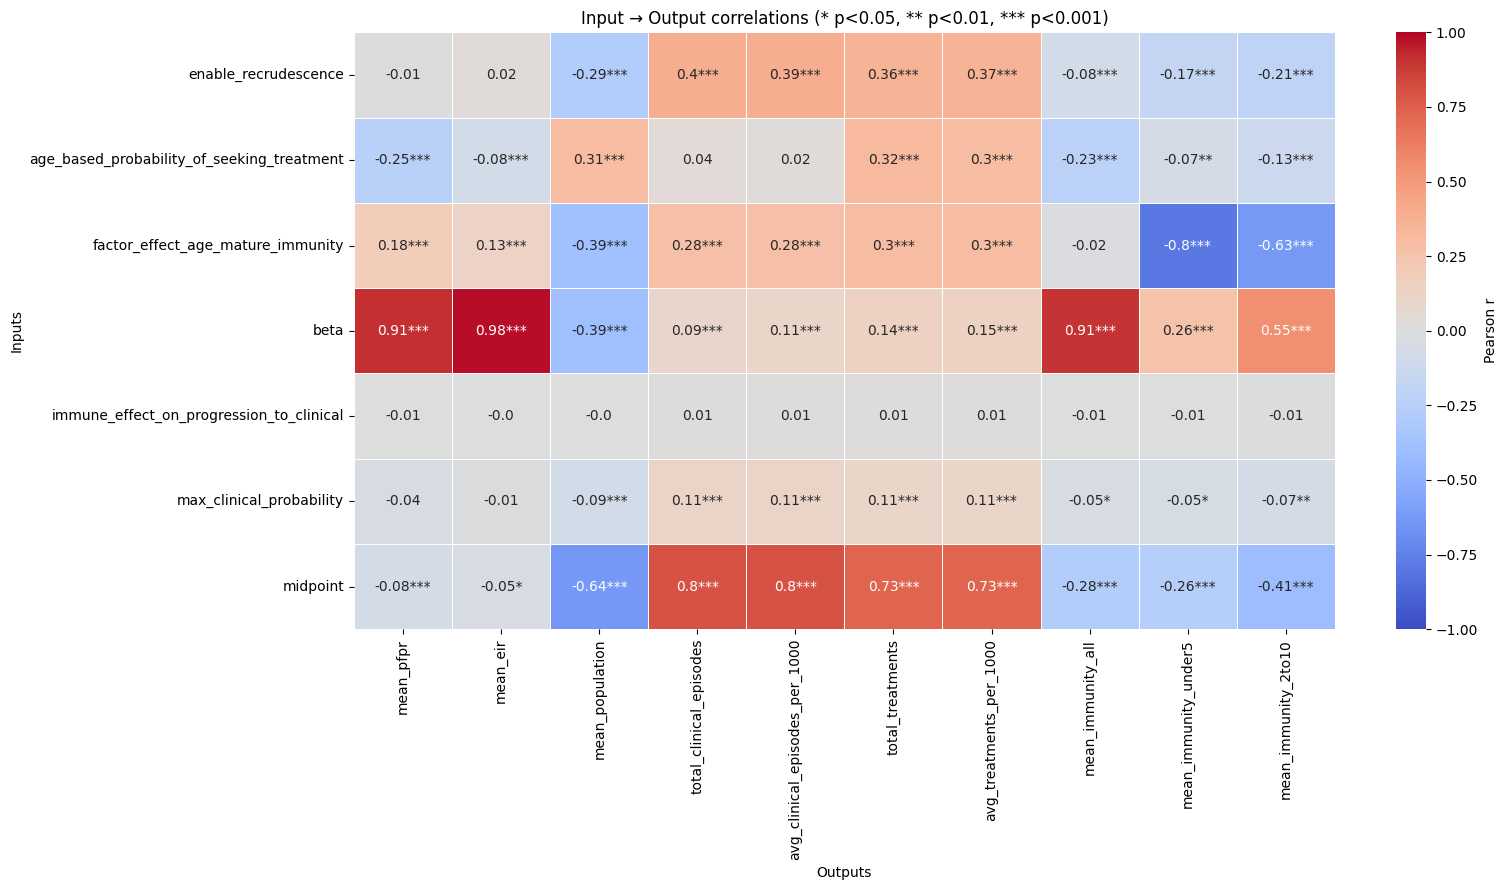

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))

sns.heatmap(
    corr_r.loc[inputs, outputs],
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    annot=annot,
    fmt="",
    linewidths=0.5,
    cbar_kws={"label": "Pearson r"}
)

plt.title("Input → Output correlations (* p<0.05, ** p<0.01, *** p<0.001)")
plt.ylabel("Inputs")
plt.xlabel("Outputs")
plt.tight_layout()
plt.show()


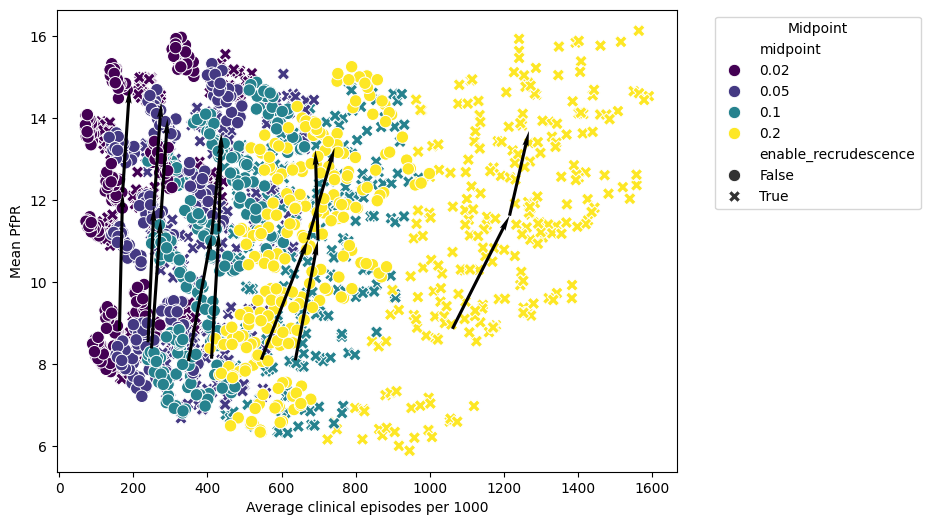

In [8]:
import seaborn as sns

plt.figure(figsize=(8,6))
ax = sns.scatterplot(
    data=df,
    x="avg_clinical_episodes_per_1000",
    y="mean_pfpr",
    hue="midpoint",
    style="enable_recrudescence",
    palette="viridis",
    s=80
)

# capture the exact colors seaborn used for each point and map them to midpoint values
sc = ax.collections[0]
facecolors = sc.get_facecolors()

df_grouped = df.groupby(['midpoint', 'beta', 'enable_recrudescence']).mean().reset_index()

mids = sorted(df["midpoint"].unique())

# build color_map using the scatter plot's facecolors so arrows match points
color_map = {}
for mid in mids:
    mask = df["midpoint"].values == mid
    if mask.any():
        first_idx = np.where(mask)[0][0]
        rgba = facecolors[first_idx]
        color_map[mid] = tuple(rgba[:3])
    else:
        color_map[mid] = (0.5, 0.5, 0.5)

for mid, group in df_grouped.groupby(["midpoint", "enable_recrudescence"]):
    x = group["avg_clinical_episodes_per_1000"].values
    y = group["mean_pfpr"].values

    ax.quiver(
        x[:-1], y[:-1],
        np.diff(x), np.diff(y),
        angles="xy", scale_units="xy", scale=1,
        # color=color_map[mid],
        width=0.005,
        headwidth=2,
    )


ax.set_xlabel("Average clinical episodes per 1000")
ax.set_ylabel("Mean PfPR")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Midpoint')
plt.show()


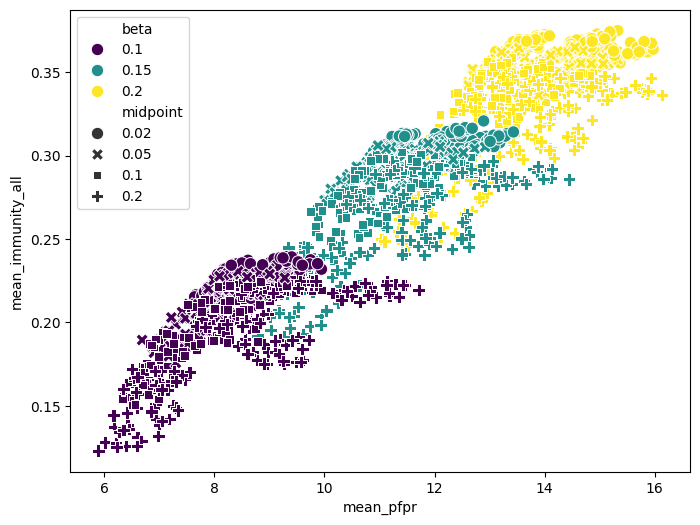

In [13]:
import seaborn as sns

plt.figure(figsize=(8,6))
ax = sns.scatterplot(
    data=df,
    y="mean_immunity_all",
    x="mean_pfpr",
    hue="beta",
    style="midpoint",
    palette="viridis",
    s=80
)


In [ ]:
import zlib
import os
import subprocess
import yaml
from concurrent.futures import ThreadPoolExecutor, as_completed

# This is the analysis flow:

# 1. Set up ranges for parameters to explore
#    - beta (transmission rate)
#    - immune_effect_on_progression_to_clinical
#    - max_clinical_probability
#    - midpoint
# 2. For each parameter set:
#   - Load and modify input YAML configuration
#   - Run the simulation
#   - Connect to the resulting SQLite database
#   - Extract and compute summary statistics
#   - take last year data, get mean PfPR, mean EIR, mean population, total clinical episodes, avg clinical episodes per 1000 people
#   - Store results for comparison (append to a csv file): input parameters + output statistics
# 3. After all runs, plot: clinical episodes per 1000 people vs PfPR

# enable_recrudescence_values = [True]
# age_based_probability_of_seeking_treatment_values = [1]
# factor_effect_age_mature_immunity_values = [0.5] # kappa
# beta_values = [0.1]
# immune_effect_on_progression_values = [5] # z
# max_clinical_probability_values = [0.90]
# midpoint_values = [0.02, 0.05, 0.1, 0.2]

enable_recrudescence_values = [True, False]
age_based_probability_of_seeking_treatment_values = [1, 0.9, 0.8]
factor_effect_age_mature_immunity_values = [0.5, 1.0, 2.0] # kappa
beta_values = [0.1, 0.15, 0.2]
immune_effect_on_progression_values = [5, 10, 15] # z
max_clinical_probability_values = [0.90, 0.95, 0.99]
midpoint_values = [0.02, 0.05, 0.1, 0.2]

os.chdir("/Users/neo/Projects/temple/malasim/build/bin")

# generate all beta values in raster file
for beta in beta_values:
    with open("./clinical_episodes/dev_beta.asc", 'r') as f:
        lines = f.readlines()
    lines[-1] = f"{beta}\n"
    with open(f"./clinical_episodes/dev_beta_{beta}.asc", 'w') as f:
        f.writelines(lines)

def run_simulation(params):
    enable_recrudescence, age_based_probability_of_seeking_treatment, factor_effect_age_mature_immunity, beta, immune_effect, max_clinical_prob, midpoint = params
    
    # Load base configuration
    with open("clinical_episodes/input.yml", 'r') as f:
        config = yaml.safe_load(f)
    
    # Modify parameters
    beta_raster_path = f"./clinical_episodes/dev_beta_{beta}.asc"
    config['spatial_settings']['grid_based']['beta_raster'] = beta_raster_path
    config['model_settings']['enable_recrudescence'] = enable_recrudescence
    config['epidemiological_parameters']['age_based_probability_of_seeking_treatment']['power']['base']= age_based_probability_of_seeking_treatment

    config['immune_system_parameters']['factor_effect_age_mature_immunity'] = factor_effect_age_mature_immunity
    config['immune_system_parameters']['immune_effect_on_progression_to_clinical'] = immune_effect
    config['immune_system_parameters']['max_clinical_probability'] = max_clinical_prob
    config['immune_system_parameters']['midpoint'] = midpoint
    
    # Create a compact 16-bit identifier for the config
    param_str = f"{enable_recrudescence}_{age_based_probability_of_seeking_treatment}_{factor_effect_age_mature_immunity}_{beta}_{immune_effect}_{max_clinical_prob}_{midpoint}"
    # Use CRC32 then take lower 16 bits to produce a 16-bit unsigned integer
    param_hash_int = zlib.crc32(param_str.encode()) & 0xFFFF

    # Save modified configuration to a temporary file
    temp_config_path = f"temp_input_{param_hash_int}.yml"
    with open(temp_config_path, 'w') as f:
        yaml.dump(config, f)
    
    # Run simulation using 16-bit hash for -j, hide stdout
    # os.system(f"./malasim -i {temp_config_path} -j {param_hash_int} > /dev/null")
    
    print(f"Start running the simulation for param set {param_str} with hash {param_hash_int}")

    subprocess.run(
        ["./malasim", "-i", temp_config_path, "-j", str(param_hash_int)],
        cwd="/Users/neo/Projects/temple/malasim/build/bin",
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL,
        check=True,
    )
    print(f"Finished simulation for param set {param_str} with hash {param_hash_int}")
    
    db_path = f"monthly_data_{param_hash_int}.db"
    # Connect to the resulting database and extract statistics
    print(f"📊 Connecting to database: {db_path}")
    conn = connect_to_db(db_path)

    summary = get_last_year_simple_summary(conn)

    conn.close()

    # Clean up temporary file
    os.remove(temp_config_path)
    os.remove(db_path)  # Assuming we don't need to keep the db
    
    return {
        'enable_recrudescence': enable_recrudescence,
        'age_based_probability_of_seeking_treatment': age_based_probability_of_seeking_treatment,
        'factor_effect_age_mature_immunity': factor_effect_age_mature_immunity,
        'beta': beta,
        'immune_effect_on_progression_to_clinical': immune_effect,
        'max_clinical_probability': max_clinical_prob,
        'midpoint': midpoint,
        'mean_pfpr': summary['mean_pfpr'],
        'mean_eir': summary['mean_eir'],
        'mean_population': summary['mean_population'],
        'total_clinical_episodes': summary['total_clinical_episodes'],
        'avg_clinical_episodes_per_1000': summary['avg_clinical_episodes_per_1000'],
        'total_treatments': summary['total_treatments'],
        'avg_treatments_per_1000': summary['avg_treatments_per_1000'],
        'mean_immunity_all': summary['mean_immunity_all'],
        'mean_immunity_under5': summary['mean_immunity_under5'],
        'mean_immunity_2to10': summary['mean_immunity_2to10'],
    }
def main():
    # Collect all parameter combinations
    param_combinations = []
    for enable_recrudescence in enable_recrudescence_values:
        for age_based_probability_of_seeking_treatment in age_based_probability_of_seeking_treatment_values:
            for factor_effect_age_mature_immunity in factor_effect_age_mature_immunity_values:
                for beta in beta_values:
                    for immune_effect in immune_effect_on_progression_values:
                        for max_clinical_prob in max_clinical_probability_values:
                            for midpoint in midpoint_values:
                                param_combinations.append((enable_recrudescence, age_based_probability_of_seeking_treatment, factor_effect_age_mature_immunity, beta, immune_effect, max_clinical_prob, midpoint))

    # Run simulations in parallel
    max_jobs = 4  # set desired concurrency
    results = []
    with ThreadPoolExecutor(max_workers=max_jobs) as executor:
        futures = {executor.submit(run_simulation, params): params for params in param_combinations}
        for future in as_completed(futures):
            try:
                results.append(future.result())
            except Exception as e:
                print(f"Simulation failed for {futures[future]}: {e}")

    # Store results to csv file
    import csv
    results_file = "clinical_episodes_results_Jan30.csv"
    file_exists = os.path.isfile(results_file)
    with open(results_file, 'a', newline='') as csvfile:
        fieldnames = ['enable_recrudescence', 'age_based_probability_of_seeking_treatment', 'factor_effect_age_mature_immunity', 'beta', 'immune_effect_on_progression_to_clinical', 'max_clinical_probability', 'midpoint',
                    'mean_pfpr', 'mean_eir', 'mean_population', 'total_clinical_episodes', 'avg_clinical_episodes_per_1000',
                    'total_treatments', 'avg_treatments_per_1000',
                    'mean_immunity_all', 'mean_immunity_under5', 'mean_immunity_2to10']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()
        for result in results:
            writer.writerow(result)

    
main()


Start running the simulation for param set True_1_0.5_0.1_5_0.9_0.02 with hash 28040
Start running the simulation for param set True_1_0.5_0.1_5_0.9_0.05 with hash 63531
Start running the simulation for param set True_1_0.5_0.1_5_0.9_0.1 with hash 10977
Start running the simulation for param set True_1_0.5_0.1_5_0.9_0.2 with hash 31579
Finished simulation for param set True_1_0.5_0.1_5_0.9_0.2 with hash 31579
📊 Connecting to database: monthly_data_31579.db
Start running the simulation for param set True_1_0.5_0.1_5_0.95_0.02 with hash 33414
Finished simulation for param set True_1_0.5_0.1_5_0.9_0.1 with hash 10977
📊 Connecting to database: monthly_data_10977.db
Start running the simulation for param set True_1_0.5_0.1_5_0.95_0.05 with hash 5925
Finished simulation for param set True_1_0.5_0.1_5_0.9_0.05 with hash 63531
📊 Connecting to database: monthly_data_63531.db
Start running the simulation for param set True_1_0.5_0.1_5_0.95_0.1 with hash 1326
Finished simulation for param set Tru